In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

import warnings
warnings.filterwarnings('ignore')

In [31]:
train = pd.read_csv('train.csv')
train = train.drop('label', axis=1)
train = train.values

test = pd.read_csv('test.csv')
test = test.values

x_train = train.copy()
x_test = test.copy()

input_dim = np.prod(x_train.shape[1:])

x_train = x_train.astype(np.float32) / 255.
x_train = x_train.reshape((x_train.shape[0], input_dim))
x_test = x_test.astype(np.float32) / 255.
x_test = x_test.reshape((x_test.shape[0], input_dim))

In [32]:
encoded_dim = 32

hidden_layer_weights = [392, 98]
hidden_layers = len(hidden_layer_weights)

In [33]:
# Create encoding layers.
def get_encoder(input, layers, encoded_dim, units):
    x = None
    for i in range(layers):
        x = keras.layers.Dense(units[i]
                               , activation='relu')(input if x is None else x)
    return keras.layers.Dense(encoded_dim
                              , activation='relu')(x)

# Create decoding layers.
def get_decoder(input, layers, input_dim, units):
    x = None
    for i in range(layers):
        x = keras.layers.Dense(units[i]
                               , activation='relu')(input if x is None else x)
    return keras.layers.Dense(input_dim
                              , activation='sigmoid')(x)

# Create a new stack of layers from existing layers with new input layer.
def add_new_input(input, layers):
    new_layer_stack = input
    for layer in layers:
        new_layer_stack = layer(new_layer_stack)
    return new_layer_stack

In [34]:
# Input to encoder.
input = keras.layers.Input(shape=(input_dim,))
# Create encoder half.
encoded_layer = get_encoder(input, hidden_layers, encoded_dim, hidden_layer_weights)
# Create decoder half.
decoded_layer = get_decoder(encoded_layer, hidden_layers, input_dim, list(reversed(hidden_layer_weights)))

# Assemble full autoencoder model.
full_model = keras.models.Model(input, decoded_layer)

# Assemble encoder model.
encoder = keras.models.Model(input, encoded_layer)

# Assemble decoder model (with new input!).
decoder_input = keras.layers.Input(shape=(encoded_dim,))
decoder = keras.models.Model(decoder_input, add_new_input(decoder_input, full_model.layers[-(hidden_layers + 1):]))

In [35]:
full_model.compile(optimizer=keras.optimizers.Adam()
                   , loss=keras.losses.binary_crossentropy
                   , metrics=[keras.metrics.binary_crossentropy])

full_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_10 (Dense)            (None, 392)               307720    
                                                                 
 dense_11 (Dense)            (None, 98)                38514     
                                                                 
 dense_12 (Dense)            (None, 32)                3168      
                                                                 
 dense_13 (Dense)            (None, 98)                3234      
                                                                 
 dense_14 (Dense)            (None, 392)               38808     
                                                                 
 dense_15 (Dense)            (None, 784)               3081

In [36]:
callbacks = [keras.callbacks.EarlyStopping(patience=2)]

history = full_model.fit(x_train
               , x_train
               , batch_size=128
               , epochs=100
               , shuffle=True
               , validation_split=.1
               , callbacks=callbacks)

Epoch 1/100
296/296 [==============================] - 3s 8ms/step - loss: 0.2021 - binary_crossentropy: 0.2021 - val_loss: 0.1352 - val_binary_crossentropy: 0.1352
Epoch 2/100
296/296 [==============================] - 2s 7ms/step - loss: 0.1220 - binary_crossentropy: 0.1220 - val_loss: 0.1129 - val_binary_crossentropy: 0.1129
Epoch 3/100
296/296 [==============================] - 2s 7ms/step - loss: 0.1081 - binary_crossentropy: 0.1081 - val_loss: 0.1040 - val_binary_crossentropy: 0.1040
Epoch 4/100
296/296 [==============================] - 3s 9ms/step - loss: 0.1008 - binary_crossentropy: 0.1008 - val_loss: 0.0992 - val_binary_crossentropy: 0.0992
Epoch 5/100
296/296 [==============================] - 4s 12ms/step - loss: 0.0961 - binary_crossentropy: 0.0961 - val_loss: 0.0952 - val_binary_crossentropy: 0.0952
Epoch 6/100
296/296 [==============================] - 4s 12ms/step - loss: 0.0930 - binary_crossentropy: 0.0930 - val_loss: 0.0922 - val_binary_crossentropy: 0.0922
Epoch 7/

In [37]:
print('test loss {}, test binary crossentropy {}'.format(*full_model.evaluate(x_test, x_test, batch_size=128)))

219/219 [==============================] - 1s 2ms/step - loss: 0.0832 - binary_crossentropy: 0.0832
test loss 0.08322792500257492, test binary crossentropy 0.08322792500257492


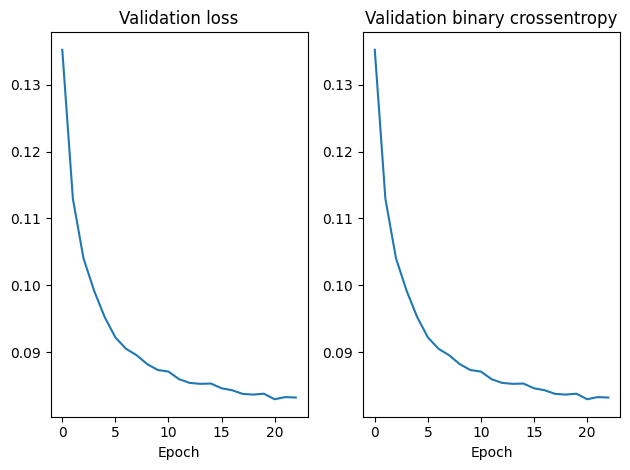

In [38]:
fig, axes = plt.subplots(1, 2)

val_loss_ax = axes[0]
val_loss_ax.plot(history.history['val_loss'])
val_loss_ax.title.set_text('Validation loss')
val_loss_ax.set_xlabel('Epoch')

val_bincross_ax = axes[1]
val_bincross_ax.plot(history.history['val_binary_crossentropy'])
val_bincross_ax.title.set_text('Validation binary crossentropy')
val_bincross_ax.set_xlabel('Epoch')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 10ms/step


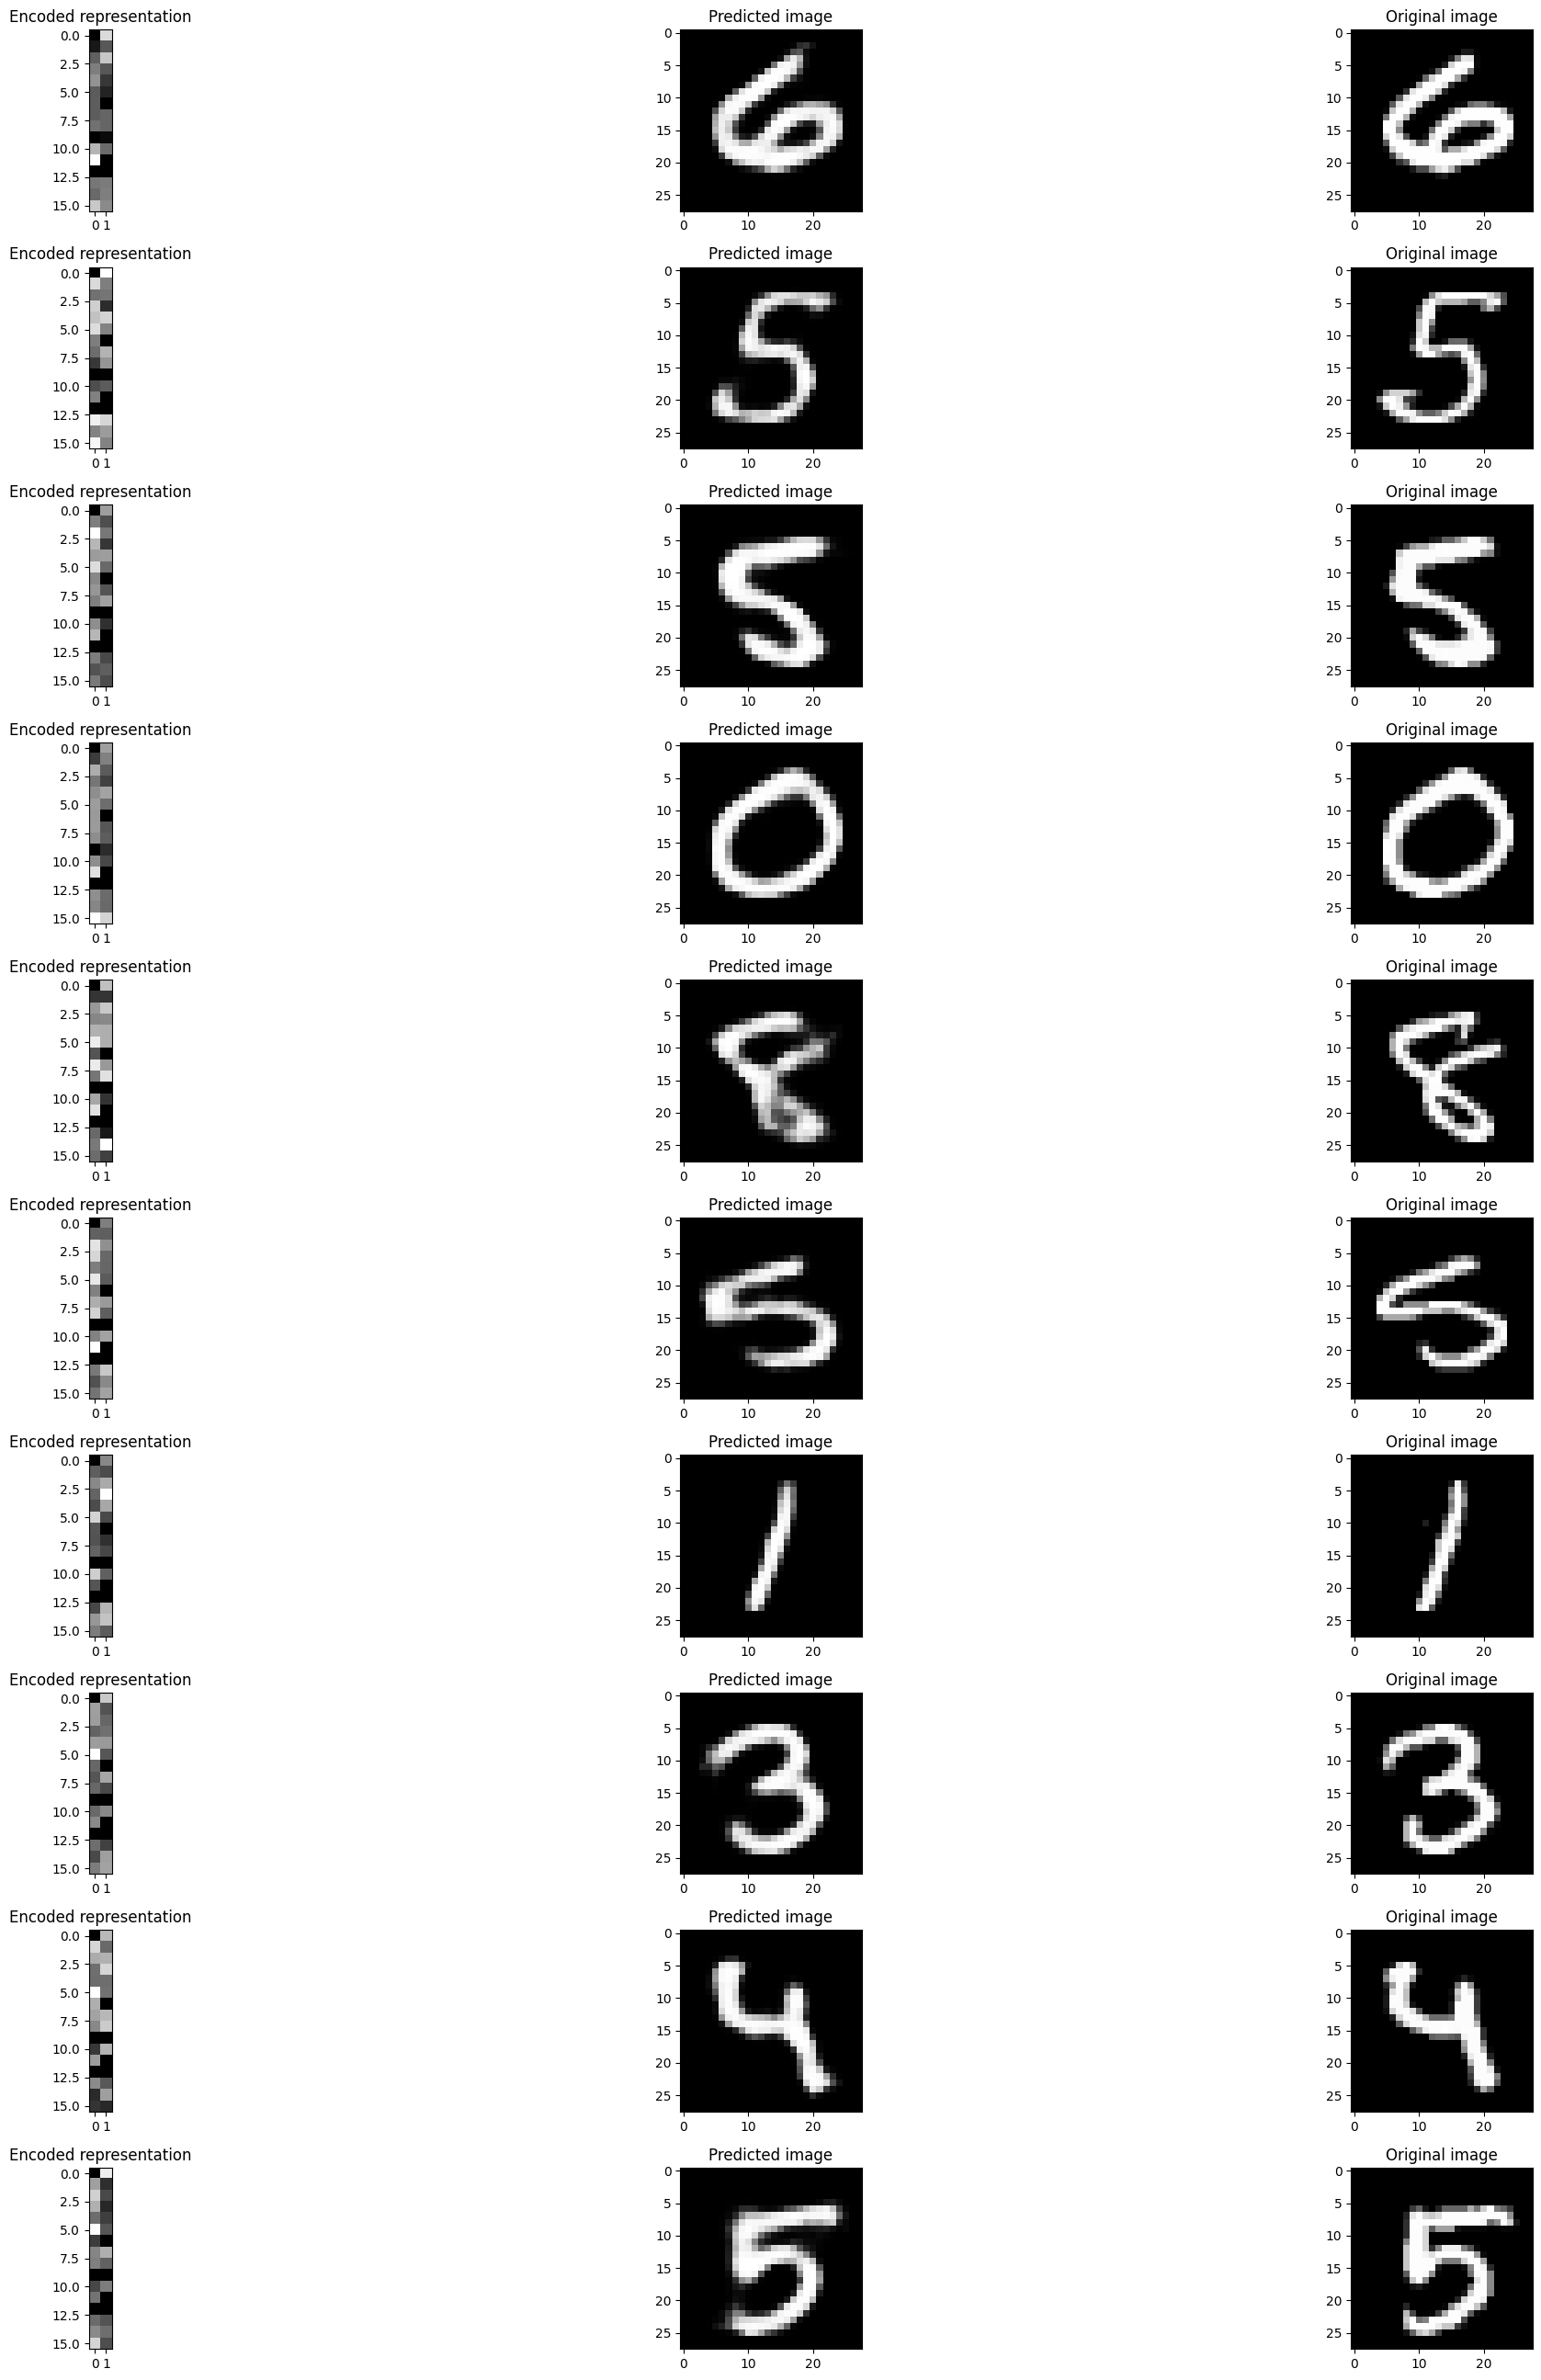

In [39]:
# Visualize X examples.
num_visualizations = 10
visualization_start_index = np.random.randint(0, len(x_test))

# Shuffle test images.
np.random.shuffle(x_test)

fig, axes = plt.subplots(1 * num_visualizations, 3)

plt.gray()

for i in range(num_visualizations):
    test_index = visualization_start_index + i
    x_encoded = encoder.predict(x_test[test_index].reshape(1, -1))
    x_predicted = decoder.predict(x_encoded)    
    encoded_columns = 2
    
    # Plot the encoded representation.
    ax_encoded = axes[i][0]
    ax_encoded.imshow(x_encoded.reshape((encoded_dim // encoded_columns, encoded_columns)))
    ax_encoded.title.set_text('Encoded representation')
    # Plot the predicted digit.
    ax_predicted = axes[i][1]
    ax_predicted.imshow(x_predicted.reshape((28, 28)))
    ax_predicted.title.set_text('Predicted image')
    # Plot the actual image.
    ax_original = axes[i][2]
    ax_original.imshow(x_test[test_index].reshape((28, 28)))
    ax_original.title.set_text('Original image')

fig.set_size_inches(26, 26)
plt.tight_layout()
plt.show()